# Managing Ansys-CFX cases

In [1]:
from cfdtoolkit.cfx.case import CFXCase

from cfdtoolkit import set_loglevel
set_loglevel('INFO')

In [2]:
from cfdtoolkit.cfx import CFXInstallation

cfx = CFXInstallation('cfx.env')
cfx.check()
cfx.pre

WindowsPath('C:/Program Files/ANSYS Inc/v202/CFX/bin/cfx5pre.exe')

## Steady-state CFX Case

A `CFXCase` is initialized with the `.cfx` file. The solver file (`.def`-file) is automatically detected as well as the `.res`-files if available.

In [3]:
from cfdtoolkit.cfx.solve import CFXSolve
from cfdtoolkit.cfx.pre import CFXPre
from cfdtoolkit.cfx.ccl import CCLFile
from cfdtoolkit.cfx.case import CFXCase

import shutil

In [4]:
cfx_filename = shutil.copy2('../../testdata/cylinderflow/steady_state/cyl_steadystate_laminar.cfx',
                            'cyl_steadystate_laminar.cfx')

In [5]:
case = CFXCase(cfx_filename)
case

<CFXCase name: cyl_steadystate_laminar>

In [6]:
case.info()

......CFX Case......
 > name: cyl_steadystate_laminar
 > Working dir: C:\Users\da4323\Documents\programming\git\cfd\pyCFDtoolkit\examples\cfx
 > Result files:
     (1/1): cyl_steadystate_laminar_001.res (cyl_steadystate_laminar_001.out)


In [7]:
case.res_files[-1].outfile.get_mesh_info()

{'Default Domain': 9284}

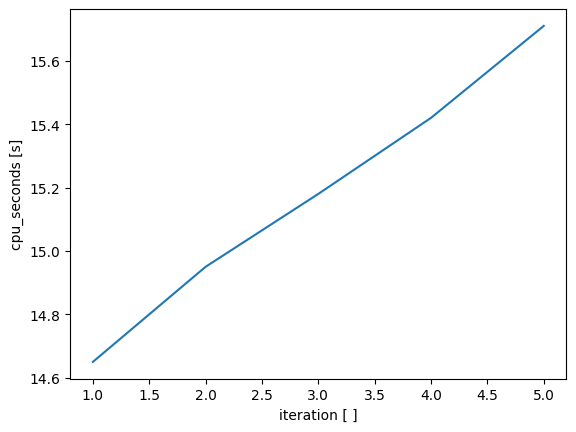

In [8]:
case.res_files[-1].outfile.data.cpu_seconds.plot()

In [9]:
awdwad

NameError: name 'awdwad' is not defined

In [ ]:
cfxfile = CFXPre('cyl_steadystate_laminar.cfx')
deffilename = cfxfile.write_def()

In [ ]:
deffilename

In [ ]:
deffile = CFXSolve(deffilename)
deffile.run(nproc=4, verbose=True)

In [ ]:
cclfilename = deffile.write_ccl()
cclfilename

In [ ]:
ccl = CCLFile(cclfilename)
ccl.flow[0].max_iterations = 5
ccl.filename

In [ ]:
cfxfile.from_h5ccl(ccl.filename)

In [ ]:
awdwad

In [ ]:
case_steady = CFXCase('../../testdata/cylinderflow/steady_state/cyl_steadystate_laminar.cfx')
case_steady

In [ ]:
case_steady.working_dir

In [ ]:
if len(case_steady.res_files) > 0:
    case_steady.reset()

### Starting a case
A case can be started from any other initial result file or from none. The number of processors to be used and the clock time can be passed as arguments. `start()` will return the command line that was constructed and executed.

Note, that when passing `wait=True` python calls the CFX solver and waits until it finishes. Only after that the next python command can be executed.

In [ ]:
case_steady = CFXCase('../../testdata/cylinderflow/steady_state/cyl_steadystate_laminar.cfx')
case_steady

In [ ]:
case_steady.ccl.flow[0].max_iterations = 5

In [ ]:
case_steady.ccl.dump()

update the path to the inlet velocity data:

In [ ]:
import pathlib
inlet_data_source = pathlib.Path("../../testdata/cylinderflow/inlet_profile_Re20.csv").resolve()
case_steady.ccl['LIBRARY/CEL/FUNCTION: inlet/DATA SOURCE'].options['File Name'] = str(inlet_data_source)
case_steady.ccl.dump()
case_steady.ccl.filename

In [ ]:
case_steady.ccl.flow[0].dump()

In [ ]:
del case_steady.ccl.expressions.options['dmfr']
del case_steady.ccl.flow[0].monitor_object['dmfr']

In [ ]:
if True:
    case_steady.start(initial_result_file=None, nproc=2, timeout=120, wait=True)

### Resume a case
You can call `.resume()` on your latest result to continue from it. Note, calling `resume` on the latest result file will not take changes in the ccl file into account! Calling it from the `CFXCase` instance however will! You may call `.update_from_ccl()` to be absolutely sure!

In [ ]:
case_steady.update_from_ccl()
case_steady.latest.resume(nproc=2)

# # or call:
# case_steady.resume(nproc=2)

### Stopping a case
You can call `.stop()` from your `CFXCase` instance to stop the run(s). This will btw. stop all running cases in the working directory!

In [ ]:
case_steady.stop()  # touches a file "stp" in the *.dir directory if exists

## Monitor Points and Expressions

User points are very helpful to analyze the runs

### Define an expression:

In [ ]:
case_steady.ccl.expressions.options['test'] = 'test'

In [ ]:
del case_steady.ccl.expressions.options['test']
del case_steady.ccl.expressions.options['dmfr']  # delete if exists from previous run for the sake of this tutorial

In [ ]:
case_steady.ccl.expressions.options['dmfr'] = 'massFlow()@OUTLET-massFlow()@INLET'

In [ ]:
case_steady.ccl.expressions.options

### Defining a monitor point:

In [ ]:
from cfdtoolkit.cfx.core import MonitorObject
case_steady.ccl.flow[0].monitor_object['dmfr'] = MonitorObject(expression_value='dmfr', coord_frame='Coord 0')
case_steady.ccl.dump()

Let's continue/resume the run as we have now a new expression set and registered it as a monitor point

In [ ]:
case_steady.resume(nproc=2)

### User Points

The example case has some user points registered which can be requested by calling the `Monitor` instance of e.g. the lates result file:

In [ ]:
case_steady.latest

In [ ]:
case_steady.latest.monitor.user_points.keys()

In [ ]:
case_steady.latest.monitor.user_points['dmfr'].plot()

In [ ]:
#if case_steady.latest:
print(len(case_steady.result_files.cfx_res_files))
print(case_steady.latest)

## Controll and change case settings

The following shows how to set and read various options in your case file.

In [ ]:
case_steady.ccl

In [ ]:
case_steady.ccl.flow[0].domains[0].get_boundary_type('inlet').dump()

In [ ]:
case_steady.ccl.to_ccl('test.ccl')

In [ ]:
#case_steady.import_ccl()

In [ ]:
case_steady.ccl.flow[0].domains[0].get_boundary_type('inlet').dump()

### Setting a new boundary condition

In [ ]:
from cfdtoolkit.cfx.boundary_conditions.inlet import NormalSpeed

In [ ]:
inlet = case_steady.ccl.flow[0].domains[0].get_boundary_type('inlet')

In [ ]:
inlet.condition = NormalSpeed(flow_regime='Subsonic', normal_speed=1)

In [ ]:
inlet.condition

In [ ]:
case_steady.ccl.flow[0].domains[0].get_boundary_type('inlet').dump()

In [ ]:
case_steady.update()